In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.datasets import mnist

# TF GPU Option
# conf = tf.ConfigProto(device_count = {'GPU': 0}) # GPU無効化
conf = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)) # GPUメモリの臨時確保を有効化
sess = tf.Session(config=conf)
keras.backend.set_session(sess)

# FNNで手書き文字を解く
この章ではTensorFlowで手書き文字のデータセット (MINIST) を解いていく。7章の末尾でも使用してるが、TFにバンドルされたKerasを使用する。KerasはTFのAPIが深層学習用としては低レベルだった頃に高レベルAPIとして作成されたWrapperライブラリで、現在は同じものがTF本体に取り込まれている。ドキュメントとしては本家の [Keras Documentation (日本語)](https://keras.io/ja/) が参照可能。

## サンプルデータ

In [2]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()
# 正規化
x_train_raw = x_train_raw.astype(np.float32) / 255
x_test_raw = x_test_raw.astype(np.float32) / 255

num_classes = 10
# 学習データ
x_train = x_train_raw.reshape(-1, 28 * 28)
x_train = x_train.astype(np.float32)
y_train = keras.utils.to_categorical(y_train_raw, num_classes)
# 検証データ
x_test = x_test_raw.reshape(-1, 28 * 28)
x_test = x_test.astype(np.float32)
y_test = keras.utils.to_categorical(y_test_raw, num_classes)

In [3]:
# データ数
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


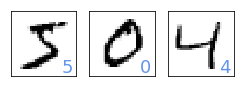

In [4]:
def show_input(img: np.ndarray):
    """画像を表示する
    
    Parameters
    ---------------
    img: np.ndarray
        表示する画像の配列 (左上原点)
    
    """
    y, x = img.shape
    hi, lo = np.max(img), np.min(img)
    img = (img - lo) / (hi - lo)
    
    offset = -0.5
    plt.imshow(img, cmap="Greys")
    plt.xticks([])
    plt.yticks([])

# 訓練データの最初の3個を表示
plt.figure(figsize=(4, 1.3))
for idx in range(3):
    acc = y_train_raw[idx]
    plt.subplot(1, 3, idx + 1)
    plt.text(21, 26, acc, color="cornflowerblue", fontsize=18)
    show_input(x_train_raw[idx])


# 2層FNNを作る
kerasのSequentialでモデルを作成する(他にfunctionalな方法もある模様)。このモデルはadd()で層を追加して使う。サンプルデータは28 * 28 の画像データ (x_train_raw) を長さ784のベクトル (x_train) への変換 & 0～1の実数への変換が行われている。正解値 (y_train) にはto_categorical()で 1 of K 符号化を使用。

新たな要素が幾つか出てきている。説明は以下の通り。

* **adam** :  勾配法よりも効率の良い最適化アルゴリズムとして提案された手法。
* **epochs**:  入力データを何回学習させるかの数。先の章の学習ループの回数に該当。
* **batch_size**:
  1エポック内で重み更新を更に分割したデータで行う際(ミニバッチ法)の分割1個当たりのデータ数。
  訓練データから勾配ベクトルを出す際に計算をデータの一部のみで行う事で、誤差を発生させ小さな
  窪みや鞍点を乗り越えられる効果を期待している (参考: 確率的勾配降下法)。

  例えば訓練データ10個でバッチサイズ2個ならば、2個で重み更新する事を5回繰り返して1エポック
  というような動きをする。数を増やす事でエポック当たりの重み更新量は減る一方、損失関数の出力は
  安定する。減らすと学習は早く進むが、学習の進展は不安定になる。


In [5]:
%%time
tf.set_random_seed(1)
model = Sequential()
model.add(Dense(16, activation="sigmoid", input_dim=28 * 28))
model.add(Dense(10, activation="softmax"))
model.compile("Adam", loss="categorical_crossentropy", metrics=["accuracy"])

res = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=2, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss {score[0]}")
print(f"Test accuracy {score[1]}")

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 2.0520 - acc: 0.3755 - val_loss: 1.7694 - val_acc: 0.5830
Epoch 2/10
 - 1s - loss: 1.5918 - acc: 0.7016 - val_loss: 1.4066 - val_acc: 0.7889
Epoch 3/10
 - 1s - loss: 1.2883 - acc: 0.8088 - val_loss: 1.1485 - val_acc: 0.8402
Epoch 4/10
 - 1s - loss: 1.0658 - acc: 0.8415 - val_loss: 0.9585 - val_acc: 0.8608
Epoch 5/10
 - 1s - loss: 0.8999 - acc: 0.8578 - val_loss: 0.8174 - val_acc: 0.8727
Epoch 6/10
 - 1s - loss: 0.7760 - acc: 0.8690 - val_loss: 0.7122 - val_acc: 0.8803
Epoch 7/10
 - 1s - loss: 0.6831 - acc: 0.8773 - val_loss: 0.6327 - val_acc: 0.8875
Epoch 8/10
 - 1s - loss: 0.6127 - acc: 0.8835 - val_loss: 0.5725 - val_acc: 0.8921
Epoch 9/10
 - 1s - loss: 0.5586 - acc: 0.8884 - val_loss: 0.5254 - val_acc: 0.8957
Epoch 10/10
 - 1s - loss: 0.5160 - acc: 0.8920 - val_loss: 0.4890 - val_acc: 0.8980
Test loss 0.48895102200508117
Test accuracy 0.898
Wall time: 6.91 s


Wall time: 37 ms
Wall time: 1.2 s


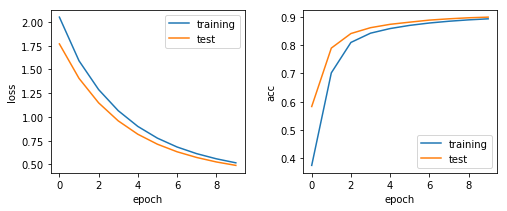

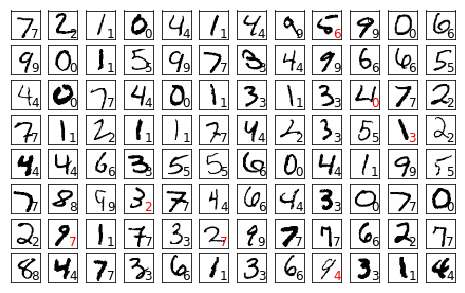

In [6]:
def show_evaluate(fitresult):
    """エポック毎の損失関数出力・正解率の推移を折れ線グラフで表示
    
    Parameters
    ------------------
    fitresult:
        model.fitの戻り値を指定
    """
    plt.figure(figsize=(8, 3))
    plt.subplots_adjust(wspace=0.3)

    plt.subplot(1, 2, 1)
    plt.plot(fitresult.history["loss"], label="training")
    plt.plot(fitresult.history["val_loss"], label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fitresult.history["acc"], label="training")
    plt.plot(fitresult.history["val_acc"], label="test")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()

def show_prediction(model, x_test):
    """テストデータ先頭96件をmodelで推論した結果を画像で表示する
    
    Parameters
    -------------
    model:
        推論に使用するkerasのモデル
    x_test:
        テストデータ
    """
    n_show = 96
    y = model.predict(x_test[:n_show])
    plt.figure(figsize=(8, 5))
    for i in range(n_show):
        predictRes = np.argmax(y[i])
        plt.subplot(8, 12, i + 1)
        plt.text(19.5, 25.5, predictRes, fontsize=12, color="black" if predictRes == y_test_raw[i] else "red")
        show_input(x_test_raw[i])

%time show_evaluate(res)
%time show_prediction(res.model, x_test)

# 活性化関数を変更する (ReLU関数)
活性化関数にはシグモイド関数が伝統的に使われてきたが、最近はReLU関数に人気がある。シグモイド関数では0や1付近に勾配が0に近くなる区間があり、その区間で学習が遅くなっていた。ReLU関数は入力が正であれば学習が停滞しない他、計算式が単純であるために計算速度が速い。

$$
    ReLU(x) =
    \begin{cases}
        x & (x \geqq 0) \\
        0 & (x < 0) \\
    \end{cases}
$$

考察  
入力が負の値の場合にニューロンの学習が進まなくなりそう。(キーワード: dead neuron)

(-3, 5)

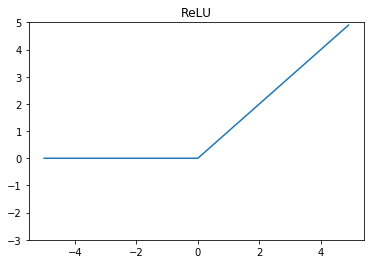

In [7]:
x = np.arange(-5, 5, 0.1)
y = np.maximum(x, 0)
plt.plot(x, y)
plt.title("ReLU")
plt.ylim(-3, 5)

In [8]:
%%time
np.random.seed(1)
tf.set_random_seed(1)
model = Sequential()
# 活性化関数をReLU関数に変更
model.add(Dense(16, activation="relu", input_dim=28 * 28))
model.add(Dense(10, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

res = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=2, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss {score[0]}")
print(f"Test accuracy {score[1]}")

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 1.7258 - acc: 0.4595 - val_loss: 1.0543 - val_acc: 0.7591
Epoch 2/10
 - 1s - loss: 0.7462 - acc: 0.8261 - val_loss: 0.5240 - val_acc: 0.8733
Epoch 3/10
 - 1s - loss: 0.4733 - acc: 0.8803 - val_loss: 0.4019 - val_acc: 0.8941
Epoch 4/10
 - 1s - loss: 0.3883 - acc: 0.8972 - val_loss: 0.3499 - val_acc: 0.9042
Epoch 5/10
 - 1s - loss: 0.3458 - acc: 0.9056 - val_loss: 0.3213 - val_acc: 0.9112
Epoch 6/10
 - 1s - loss: 0.3198 - acc: 0.9118 - val_loss: 0.3024 - val_acc: 0.9141
Epoch 7/10
 - 1s - loss: 0.3017 - acc: 0.9164 - val_loss: 0.2915 - val_acc: 0.9172
Epoch 8/10
 - 1s - loss: 0.2888 - acc: 0.9195 - val_loss: 0.2807 - val_acc: 0.9209
Epoch 9/10
 - 1s - loss: 0.2783 - acc: 0.9223 - val_loss: 0.2734 - val_acc: 0.9228
Epoch 10/10
 - 1s - loss: 0.2695 - acc: 0.9243 - val_loss: 0.2659 - val_acc: 0.9243
Test loss 0.2659154332607985
Test accuracy 0.9243
Wall time: 6.84 s


Wall time: 37 ms
Wall time: 1.32 s


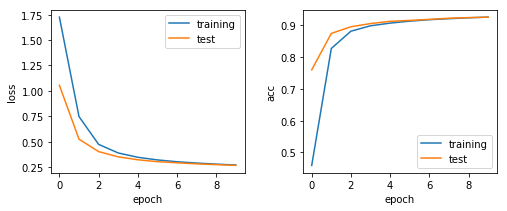

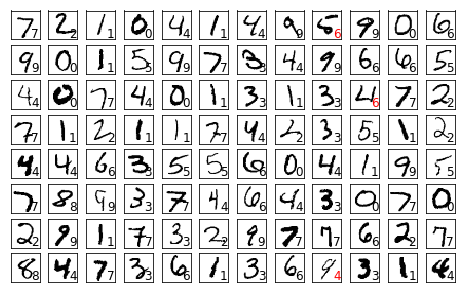

In [9]:
%time show_evaluate(res)
%time show_prediction(res.model, x_test)

## 重みを可視化する
入力から中間層16ユニットへ繋がる重み部分を可視化する(バイアス項は除外)。見ても人間には分からないが、訓練データの特徴はこの重みの中に組み込まれる。黒に近ければ近い程ニューロンが強く反応している事を示し、画像認識で重要度の高い画素であることが分かる。

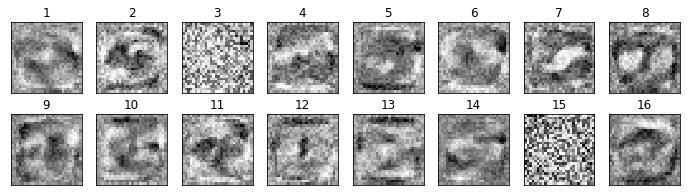

In [10]:
# 0: 中間層 (0層)
hidlay = model.layers[0]
# 0: 入力変数の重み、1: バイアスの重み
w = hidlay.get_weights()[0]

plt.figure(figsize=(12, 3))
plt.subplots_adjust(hspace=0.3)
for i in range(hidlay.units):
    each_w = w[:,i]
    each_w = each_w.reshape(28, 28)
    
    plt.subplot(2, 8, i + 1)
    plt.title(i + 1)
    show_input(each_w)


# 局所的な構造を学習させる (CNN)
これまでのFNNは全結合層から成っていた。しかし全結合は個別の画素を学習するため、周囲の画素から成る局所的なパターンは学習出来ていない。この局所的なパターンが学習できれば画素の連なりから成るエッジの学習などができ、更なる画像認識精度の向上が期待される。これを実現する方法として **畳込みニューラルネットワーク (CNN)** というものがある。

## 空間フィルタ
直線や曲線、円などの形 (空間の情報) を取出す方法として **空間フィルター** という画像処理法がある。これは各画素に対し、一帯の画素と2次元の行列のフィルター (合計: 1, サイズ: 3\*3 → 中央画素の有る正方形が一般的) のアダマール積の和を中央画素のフィルタ後の値とする事で行う。以下がその式になる。

$$
    g(i, j) = \sum_{u = -1}^1 \sum_{v = -1}^1 x_{i + u, j + v} h_{u + 1, v + 1}
$$

なお、フィルタ適用後の画像は縦横サイズが小さくなるが、フィルタを重ねる際に不都合があるため入力画像に余白を入れる(固定値0が一般)。この処理を **パディング** と呼ぶ。また、フィルタの適用間隔は1以外も可能でこの間隔を **スライド** と呼ぶ。

コードとしては次のように実装できる (高速化のため、複数画素に対して一括操作している)。以下では「ぼかし」「横輪郭の強調」「縦輪郭の強調」の3つを行っている。

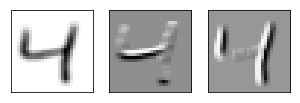

In [18]:
def conv2d(img: np.ndarray, filter: np.ndarray):
    # 中央画素周囲の余白数
    f_padsize = int(filter.shape[0] / 2)
    f_vector = filter.flatten()
    
    # 空間フィルタの各要素向けに画像を作成
    i = 0
    outimg = np.empty((*img.shape, filter.size), img.dtype)
    wrkimg = np.pad(img, (f_padsize, f_padsize), "constant")
    # 入力画像から少しずらした画像をフィルタ要素数分だけ生成 (右下 → 左下 → 右中 → ... → 左上)
    for y in range(f_padsize, -f_padsize - 1, -1):
        for x in range(f_padsize, -f_padsize - 1, -1):
            tmp = np.roll(wrkimg, (y, x), axis=(0, 1))
            tmp = tmp[f_padsize:-f_padsize,f_padsize:-f_padsize]
            outimg[:,:,i] = tmp
            i += 1

    # 空間フィルタをかける
    outimg = outimg * f_vector
    outimg = np.sum(outimg, axis=2)
    return outimg

img = x_train_raw[2]
filters = [
    np.array([
        [0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1]
    ]),
    np.array([
        [1, 1, 1],
        [1, 1, 1],
        [-2, -2, -2]
    ]),
    np.array([
        [1, 1, -2],
        [1, 1, -2],
        [1, 1, -2]
    ])
]
plt.figure(figsize=(5, 2))
for i, f in enumerate(filters):
    out = conv2d(img, f)
    plt.subplot(1, 3, i + 1)
    show_input(out)


## 畳込み層を入れる
畳み込み層ではユニット毎の空間フィルターを学習させる。またフィルターは実際にはカラーチャネルを加えた3次元となる。よってユニット番号の次元が加わり、入力\[x,y,c\]に対し出力は\[u,x,y,c\]になる。

コードではConv2D(ユニット数, フィルターサイズ)が畳込み層になる。パディングはpadding="same"で入力と出力の縦横サイズが一致し、input_shape=(28, 28, 1)がinput_dimの代わりに必要となる。出力は画像の行列になるため、全結合層と繋ぐ際はFlatten()でベクトルに変換してから繋ぐ。

In [12]:
from tensorflow.keras.layers import Conv2D, Flatten
x_train_cnn = x_train_raw[:,:,:,np.newaxis]
x_test_cnn = x_test_raw[:,:,:,np.newaxis]

model = Sequential()
# 畳込み層に差し替える
model.add(Conv2D(8, (3, 3), padding="same", input_shape=(28, 28, 1), activation="relu"))
model.add(Flatten())
model.add(Dense(10, "softmax"))
model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

fitres = model.fit(x_train_cnn, y_train, epochs=10, batch_size=1000, verbose=2, validation_data=(x_test_cnn, y_test))
score = model.evaluate(x_test_cnn, y_test, verbose=0)

print(f"Test loss {score[0]}")
print(f"Test accuracy {score[1]}")

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 1.0138 - acc: 0.7828 - val_loss: 0.3802 - val_acc: 0.8954
Epoch 2/10
 - 1s - loss: 0.3278 - acc: 0.9069 - val_loss: 0.2742 - val_acc: 0.9217
Epoch 3/10
 - 1s - loss: 0.2551 - acc: 0.9287 - val_loss: 0.2261 - val_acc: 0.9344
Epoch 4/10
 - 1s - loss: 0.2145 - acc: 0.9398 - val_loss: 0.1908 - val_acc: 0.9473
Epoch 5/10
 - 1s - loss: 0.1835 - acc: 0.9495 - val_loss: 0.1669 - val_acc: 0.9548
Epoch 6/10
 - 1s - loss: 0.1601 - acc: 0.9565 - val_loss: 0.1500 - val_acc: 0.9584
Epoch 7/10
 - 1s - loss: 0.1418 - acc: 0.9616 - val_loss: 0.1364 - val_acc: 0.9615
Epoch 8/10
 - 1s - loss: 0.1275 - acc: 0.9657 - val_loss: 0.1225 - val_acc: 0.9649
Epoch 9/10
 - 1s - loss: 0.1157 - acc: 0.9690 - val_loss: 0.1120 - val_acc: 0.9676
Epoch 10/10
 - 1s - loss: 0.1060 - acc: 0.9715 - val_loss: 0.1050 - val_acc: 0.9707
Test loss 0.10495432577133179
Test accuracy 0.9707


Wall time: 37 ms
Wall time: 1.36 s


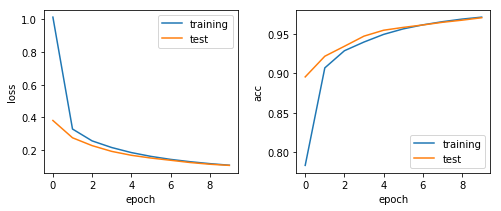

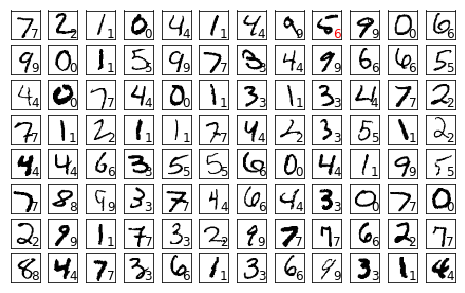

In [13]:
%time show_evaluate(fitres)
%time show_prediction(fitres.model, x_test_cnn)

## 畳み込み層の重みを可視化する
畳み込み層の学習結果と空間フィルタの処理結果を可視化する。これらの結果に学習された特徴が反映される。

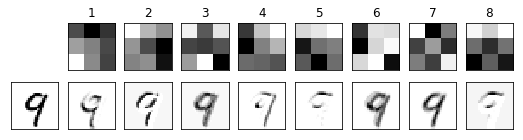

In [14]:
def get_conv_output(model, layer_num, input_data):
    plt.figure(figsize=(9, 2))
    plt.gray()

    layer = model.get_layer(index=layer_num)
    kernel_size = layer.kernel_size
    weights = layer.get_weights()[0]
    units = weights.shape[-1]

    # 元画像
    plt.subplot(2, units + 1, units + 2)
    show_input(input_data[:,:,0])
    
    # 空間フィルタ
    for u in range(units):
        weight = weights[:,:,0,u].reshape(*kernel_size)
        plt.subplot(2, units + 1, u + 2)
        plt.title(u + 1)
        show_input(weight)

    # 畳み込み画像
    get_lay_output = keras.backend.function([model.layers[0].input], [model.layers[layer_num].output])
    res_cnn = get_lay_output([input_data[np.newaxis,]])
    # [output,n,y,x,ch] -> [y,x,ch]
    res_cnn = res_cnn[0][0]
    res_len = res_cnn.shape[2]
    for u in range(res_len):
        plt.subplot(2, units + 1, u + units + 3)
        show_input(res_cnn[:,:,u])

get_conv_output(model, 0, x_test_cnn[12])

# さらなる認識精度向上

## プーリング
入力画像を小さな領域に分割し、各領域毎に最大の出力を持つニューロンの値を出力する処理を行う (**最大プーリング**)。これには認識させる特徴への位置ずれ耐性を高める他、結果に貢献しないニューロンを間引く事で処理量が削減できる。

## ドロップアウト
学習時に一定確率(p)で入力層や出力層のニューロンの一部を選出し学習させ、ミニバッチ毎に選出をし直す。予測時には全てのニューロンを使用し、出力の辻褄が合うよう一定確率の分(p)を掛ける。一般に学習機は複数用意し合議を取らせると性能が向上するが (アンサンブル学習)、ドロップアウトには同様の効果があると考えられる。

# 集大成モデルを作る

In [26]:
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D
x_train_cnn = x_train_raw[:,:,:,np.newaxis]
x_test_cnn = x_test_raw[:,:,:,np.newaxis]

model = Sequential()
# 畳込みを2層重ねる
model.add(Conv2D(16, (3, 3), input_shape=(28, 28, 1), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 畳込みを更に1層重ねる
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

# 全結合2層でクラス分類
model.add(Dense(128, "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, "softmax"))

model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])
fitres = model.fit(x_train_cnn, y_train, epochs=20, batch_size=1000, verbose=2, validation_data=(x_test_cnn, y_test))
score = model.evaluate(x_test_cnn, y_test, verbose=0)

print(f"Test loss {score[0]}")
print(f"Test accuracy {score[1]}")

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 3s - loss: 0.7154 - acc: 0.7835 - val_loss: 0.1349 - val_acc: 0.9607
Epoch 2/20
 - 2s - loss: 0.1415 - acc: 0.9573 - val_loss: 0.0628 - val_acc: 0.9788
Epoch 3/20
 - 2s - loss: 0.0947 - acc: 0.9712 - val_loss: 0.0517 - val_acc: 0.9832
Epoch 4/20
 - 2s - loss: 0.0742 - acc: 0.9778 - val_loss: 0.0379 - val_acc: 0.9867
Epoch 5/20
 - 2s - loss: 0.0625 - acc: 0.9810 - val_loss: 0.0332 - val_acc: 0.9892
Epoch 6/20
 - 2s - loss: 0.0541 - acc: 0.9832 - val_loss: 0.0311 - val_acc: 0.9893
Epoch 7/20
 - 2s - loss: 0.0468 - acc: 0.9857 - val_loss: 0.0277 - val_acc: 0.9899
Epoch 8/20
 - 2s - loss: 0.0439 - acc: 0.9866 - val_loss: 0.0248 - val_acc: 0.9915
Epoch 9/20
 - 2s - loss: 0.0394 - acc: 0.9873 - val_loss: 0.0242 - val_acc: 0.9911
Epoch 10/20
 - 2s - loss: 0.0365 - acc: 0.9886 - val_loss: 0.0243 - val_acc: 0.9912
Epoch 11/20
 - 2s - loss: 0.0333 - acc: 0.9895 - val_loss: 0.0246 - val_acc: 0.9914
Epoch 12/20
 - 2s - loss: 0.0319 - 

Wall time: 41 ms
Wall time: 1.06 s


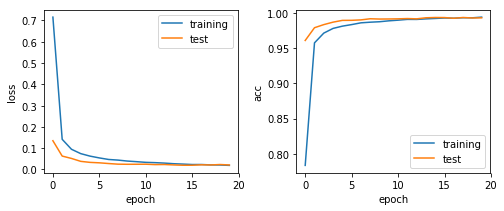

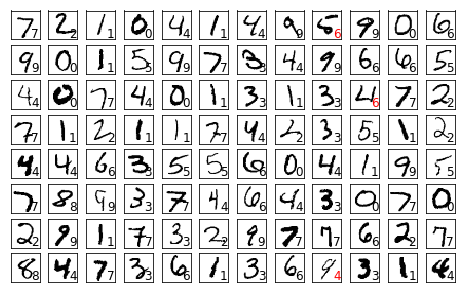

In [27]:
%time show_evaluate(fitres)
%time show_prediction(res.model, x_test)